In [ ]:
import zipfile
import os
import numpy as np
import cv2
from google.colab import drive
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import models
import seaborn as sns
from torchsummary import summary

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading zip file from google drive and extracting it

In [ ]:
zip_path = "/content/drive/My Drive/rgb_project/rgb_cropped_images.zip"
extract_dir = "/content/images"

os.makedirs(extract_dir, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

os.listdir(extract_dir)

['rgb_cropped_images']

In [ ]:
image_sizes=[700, 512, 256]

Creating a mapping of the training and testing data for images with different sizes.

In [ ]:
train_loader_mappings = {}
test_loader_mappings = {}

def get_dataloaders(data_dir, batch_size=16, img_size=128):
  for image_size in image_sizes:
      transform = transforms.Compose([
          transforms.Resize((img_size, img_size)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
      ])

      dataset = datasets.ImageFolder(root=f"{data_dir}/{image_size}_{image_size}", transform=transform)

      class_names = dataset.classes

      train_size = int(0.8 * len(dataset))
      test_size = len(dataset) - train_size

      train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

      train_loader_mappings.update({image_size:train_loader})
      test_loader_mappings.update({image_size:test_loader})

  return train_loader_mappings, test_loader_mappings, class_names

In [ ]:
train_loader_mappings, test_loader_mappings, class_names = get_dataloaders("images/rgb_cropped_images")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Custom CNN**

In [ ]:
class CustomCnn(nn.Module):
    def __init__(self, num_classes):
        super(CustomCnn, self).__init__()

        # Convolutional blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2d = nn.Dropout2d(0.1)

        # Adaptive pooling to reduce spatial size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

        # Activation
        self.act = nn.LeakyReLU(0.1)

        self._initialize_weights()

    def forward(self, x):
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = self.pool(self.act(self.bn2(self.conv2(x))))
        x = self.pool(self.act(self.bn3(self.conv3(x))))
        x = self.dropout2d(x)

        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)

        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [ ]:
def evaluate_model(model, test_loader, class_names, device, image_size):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=90, cmap='Blues')
    plt.title(f'Confusion Matrix - {image_size}')
    plt.show()

    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(f"Classification Report-{image_size}")
    print(report)

In [ ]:
def train_model(train_loader, class_names, device, num_epochs):
    model = CustomCnn(num_classes=len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)  # Reduce LR every 7 epochs

    train_losses = []
    best_acc = 0.0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}")

    return model

In [ ]:
epochs = 20

In [ ]:
trained_model_mappings = {}
for image_size in image_sizes:
  print(f"\nStarting with image size = {image_size}")
  tm = train_model(train_loader_mappings[image_size], class_names, device, epochs)
  trained_model_mappings.update({image_size:tm})


Starting with image size = 700
Epoch 1/20, Loss: 2.6068
Epoch 2/20, Loss: 1.8984
Epoch 3/20, Loss: 1.6046
Epoch 4/20, Loss: 1.5170
Epoch 5/20, Loss: 1.3415
Epoch 6/20, Loss: 1.2808
Epoch 7/20, Loss: 1.2532
Epoch 8/20, Loss: 1.0349
Epoch 9/20, Loss: 1.0077
Epoch 10/20, Loss: 1.0052
Epoch 11/20, Loss: 0.9893
Epoch 12/20, Loss: 1.0042
Epoch 13/20, Loss: 0.9737
Epoch 14/20, Loss: 0.9028
Epoch 15/20, Loss: 0.9160
Epoch 16/20, Loss: 0.9087
Epoch 17/20, Loss: 0.9467
Epoch 18/20, Loss: 0.9081
Epoch 19/20, Loss: 0.9168
Epoch 20/20, Loss: 0.9281

Starting with image size = 512
Epoch 1/20, Loss: 2.7824
Epoch 2/20, Loss: 2.0614
Epoch 3/20, Loss: 1.8015
Epoch 4/20, Loss: 1.5012
Epoch 5/20, Loss: 1.4373
Epoch 6/20, Loss: 1.3237
Epoch 7/20, Loss: 1.2475
Epoch 8/20, Loss: 1.1348
Epoch 9/20, Loss: 1.0706
Epoch 10/20, Loss: 1.0514
Epoch 11/20, Loss: 1.0236
Epoch 12/20, Loss: 1.0007
Epoch 13/20, Loss: 0.9742
Epoch 14/20, Loss: 1.0174
Epoch 15/20, Loss: 0.9568
Epoch 16/20, Loss: 0.9677
Epoch 17/20, Loss:

In [ ]:
model = CustomCnn(num_classes=len(class_names)).to(device)
summary(model, input_size=(3, 128, 128))  # (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         LeakyReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         LeakyReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
        LeakyReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
        Dropout2d-13          [-1, 128, 16, 16]               0
AdaptiveAvgPool2d-14            [-1, 12

Image size: 700


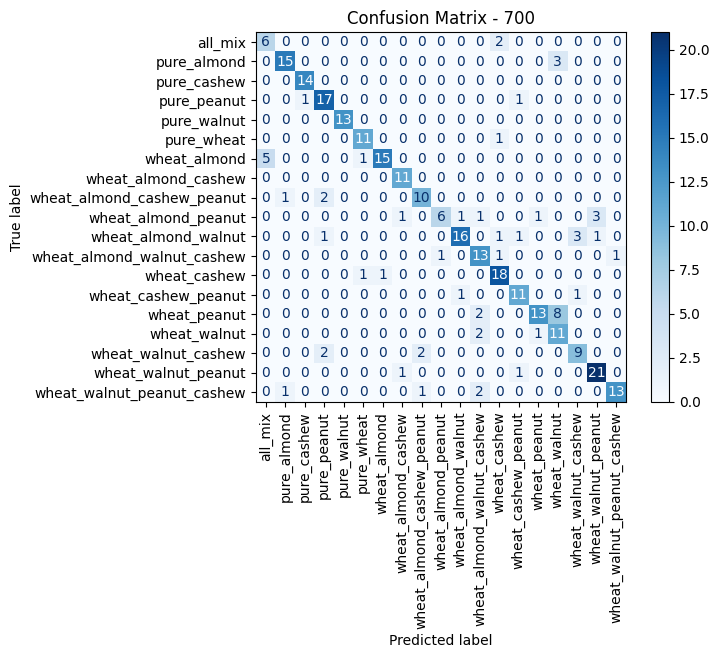

Classification Report-700
                            precision    recall  f1-score   support

                   all_mix       0.55      0.75      0.63         8
               pure_almond       0.88      0.83      0.86        18
               pure_cashew       0.93      1.00      0.97        14
               pure_peanut       0.77      0.89      0.83        19
               pure_walnut       1.00      1.00      1.00        13
                pure_wheat       0.85      0.92      0.88        12
              wheat_almond       0.94      0.71      0.81        21
       wheat_almond_cashew       0.85      1.00      0.92        11
wheat_almond_cashew_peanut       0.77      0.77      0.77        13
       wheat_almond_peanut       0.86      0.46      0.60        13
       wheat_almond_walnut       0.89      0.70      0.78        23
wheat_almond_walnut_cashew       0.65      0.81      0.72        16
              wheat_cashew       0.78      0.90      0.84        20
       wheat_cashew_p

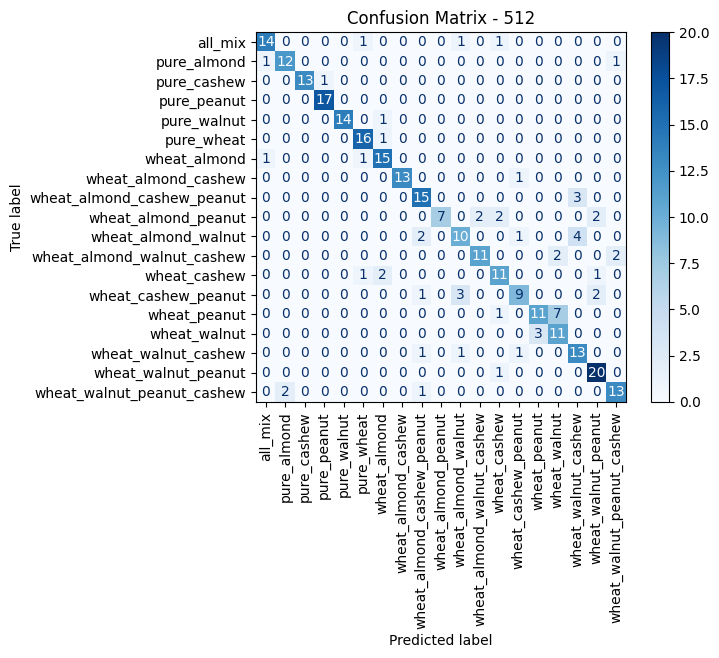

Classification Report-512
                            precision    recall  f1-score   support

                   all_mix       0.88      0.82      0.85        17
               pure_almond       0.86      0.86      0.86        14
               pure_cashew       1.00      0.93      0.96        14
               pure_peanut       0.94      1.00      0.97        17
               pure_walnut       1.00      0.93      0.97        15
                pure_wheat       0.84      0.94      0.89        17
              wheat_almond       0.79      0.88      0.83        17
       wheat_almond_cashew       1.00      0.93      0.96        14
wheat_almond_cashew_peanut       0.75      0.83      0.79        18
       wheat_almond_peanut       1.00      0.54      0.70        13
       wheat_almond_walnut       0.67      0.59      0.62        17
wheat_almond_walnut_cashew       0.85      0.73      0.79        15
              wheat_cashew       0.69      0.73      0.71        15
       wheat_cashew_p

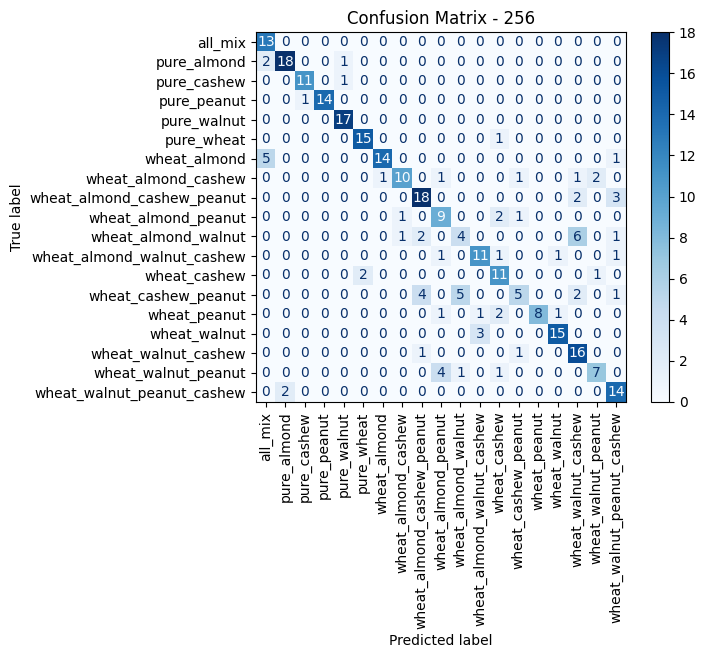

Classification Report-256
                            precision    recall  f1-score   support

                   all_mix       0.65      1.00      0.79        13
               pure_almond       0.90      0.86      0.88        21
               pure_cashew       0.92      0.92      0.92        12
               pure_peanut       1.00      0.93      0.97        15
               pure_walnut       0.89      1.00      0.94        17
                pure_wheat       0.88      0.94      0.91        16
              wheat_almond       0.93      0.70      0.80        20
       wheat_almond_cashew       0.83      0.62      0.71        16
wheat_almond_cashew_peanut       0.72      0.78      0.75        23
       wheat_almond_peanut       0.56      0.69      0.62        13
       wheat_almond_walnut       0.40      0.29      0.33        14
wheat_almond_walnut_cashew       0.73      0.73      0.73        15
              wheat_cashew       0.61      0.79      0.69        14
       wheat_cashew_p

In [ ]:
for image_size in image_sizes:
  print(f"Image size: {image_size}")
  evaluate_model(trained_model_mappings[image_size], test_loader_mappings[image_size], class_names, device, image_size)

# **ResNet-18**

In [ ]:
def train_resnet(train_loader, test_loader, image_size):
    # Load pretrained ResNet-18
  resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

  # Modify the final layer
  num_classes = len(class_names)
  resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

  resnet = resnet.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(resnet.parameters(), lr=0.001)

  for epoch in range(epochs):
      resnet.train()
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = resnet(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          _, preds = torch.max(outputs, 1)
          correct += (preds == labels).sum().item()
          total += labels.size(0)

      train_loss = running_loss / len(train_loader)
      train_acc = correct / total

      # Validation Loop
      resnet.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = resnet(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()

              _, preds = torch.max(outputs, 1)
              val_correct += (preds == labels).sum().item()
              val_total += labels.size(0)

      val_loss /= len(test_loader)
      val_acc = val_correct / val_total

      print(f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  # Save the resnet
  torch.save(resnet.state_dict(), f'resnet18_finetuned_{image_size}.pth')
  return resnet

In [ ]:
resnet_mappings={}
for image_size in image_sizes:
  print(f"\nStarting with image size = {image_size}")
  resnet=train_resnet(train_loader_mappings[image_size], test_loader_mappings[image_size], image_size)
  resnet_mappings.update({image_size:resnet})


Starting with image size = 700
Epoch [1/20] Train Loss: 1.7990, Train Acc: 0.4885 Val Loss: 2.1360, Val Acc: 0.4737
Epoch [2/20] Train Loss: 0.9473, Train Acc: 0.7072 Val Loss: 1.3969, Val Acc: 0.5855
Epoch [3/20] Train Loss: 0.6050, Train Acc: 0.8125 Val Loss: 1.0276, Val Acc: 0.7007
Epoch [4/20] Train Loss: 0.5421, Train Acc: 0.8438 Val Loss: 0.7142, Val Acc: 0.7796
Epoch [5/20] Train Loss: 0.4292, Train Acc: 0.8758 Val Loss: 1.1143, Val Acc: 0.7171
Epoch [6/20] Train Loss: 0.4975, Train Acc: 0.8512 Val Loss: 0.6845, Val Acc: 0.8191
Epoch [7/20] Train Loss: 0.2623, Train Acc: 0.9169 Val Loss: 0.8868, Val Acc: 0.8191
Epoch [8/20] Train Loss: 0.2895, Train Acc: 0.9161 Val Loss: 0.8700, Val Acc: 0.7829
Epoch [9/20] Train Loss: 0.2205, Train Acc: 0.9268 Val Loss: 1.0338, Val Acc: 0.7007
Epoch [10/20] Train Loss: 0.2329, Train Acc: 0.9334 Val Loss: 1.4180, Val Acc: 0.6645
Epoch [11/20] Train Loss: 0.1866, Train Acc: 0.9482 Val Loss: 0.2986, Val Acc: 0.9112
Epoch [12/20] Train Loss: 0.119


Classification Report - 700:
                            precision    recall  f1-score   support

                   all_mix       0.78      0.88      0.82         8
               pure_almond       0.95      1.00      0.97        18
               pure_cashew       0.58      1.00      0.74        14
               pure_peanut       1.00      0.58      0.73        19
               pure_walnut       0.62      1.00      0.76        13
                pure_wheat       0.80      1.00      0.89        12
              wheat_almond       1.00      0.71      0.83        21
       wheat_almond_cashew       0.61      1.00      0.76        11
wheat_almond_cashew_peanut       0.77      0.77      0.77        13
       wheat_almond_peanut       0.92      0.85      0.88        13
       wheat_almond_walnut       0.96      1.00      0.98        23
wheat_almond_walnut_cashew       0.79      0.69      0.73        16
              wheat_cashew       1.00      0.75      0.86        20
       wheat_cash

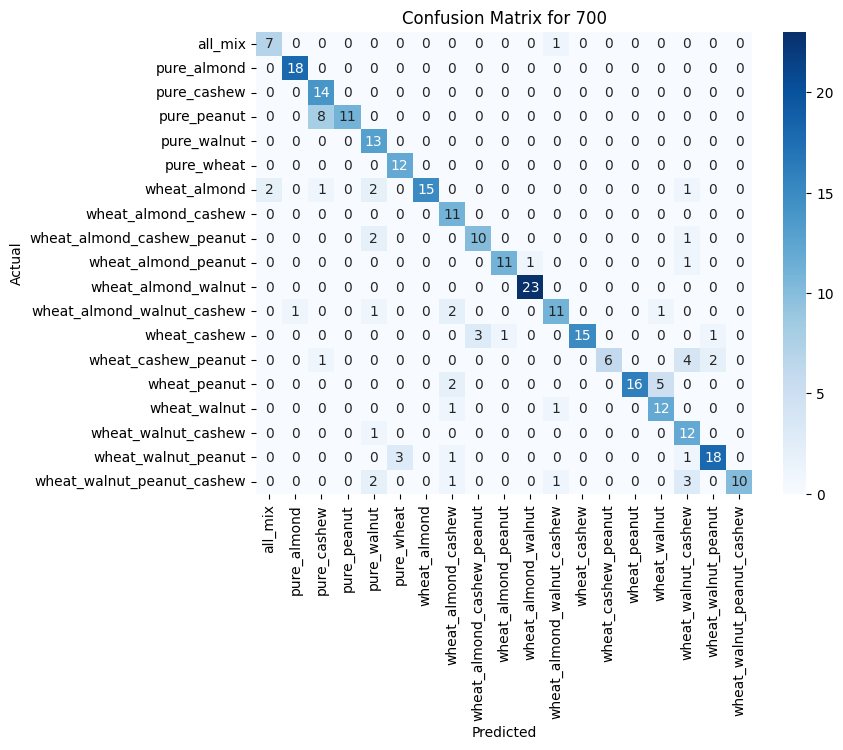


Classification Report - 512:
                            precision    recall  f1-score   support

                   all_mix       1.00      0.88      0.94        17
               pure_almond       0.92      0.86      0.89        14
               pure_cashew       1.00      0.93      0.96        14
               pure_peanut       1.00      1.00      1.00        17
               pure_walnut       1.00      1.00      1.00        15
                pure_wheat       0.94      0.88      0.91        17
              wheat_almond       0.68      1.00      0.81        17
       wheat_almond_cashew       0.32      1.00      0.48        14
wheat_almond_cashew_peanut       1.00      0.50      0.67        18
       wheat_almond_peanut       1.00      0.08      0.14        13
       wheat_almond_walnut       0.67      0.94      0.78        17
wheat_almond_walnut_cashew       0.43      1.00      0.60        15
              wheat_cashew       1.00      0.33      0.50        15
       wheat_cash

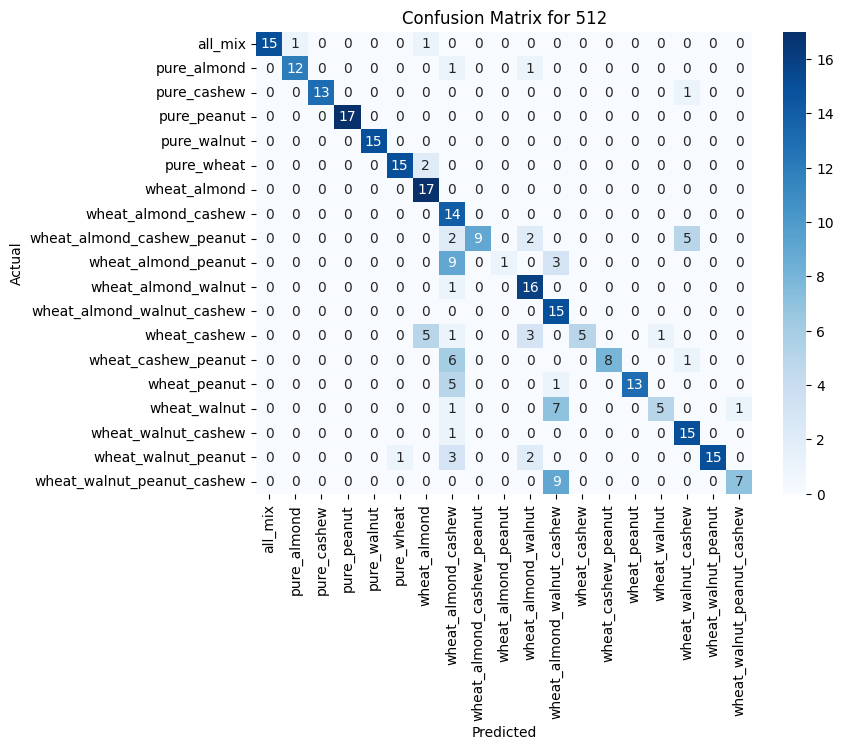


Classification Report - 256:
                            precision    recall  f1-score   support

                   all_mix       1.00      0.69      0.82        13
               pure_almond       0.95      0.90      0.93        21
               pure_cashew       1.00      0.67      0.80        12
               pure_peanut       1.00      1.00      1.00        15
               pure_walnut       0.89      1.00      0.94        17
                pure_wheat       0.87      0.81      0.84        16
              wheat_almond       0.90      0.95      0.93        20
       wheat_almond_cashew       0.78      0.88      0.82        16
wheat_almond_cashew_peanut       0.82      0.78      0.80        23
       wheat_almond_peanut       0.57      0.62      0.59        13
       wheat_almond_walnut       0.50      0.86      0.63        14
wheat_almond_walnut_cashew       0.58      0.93      0.72        15
              wheat_cashew       0.89      0.57      0.70        14
       wheat_cash

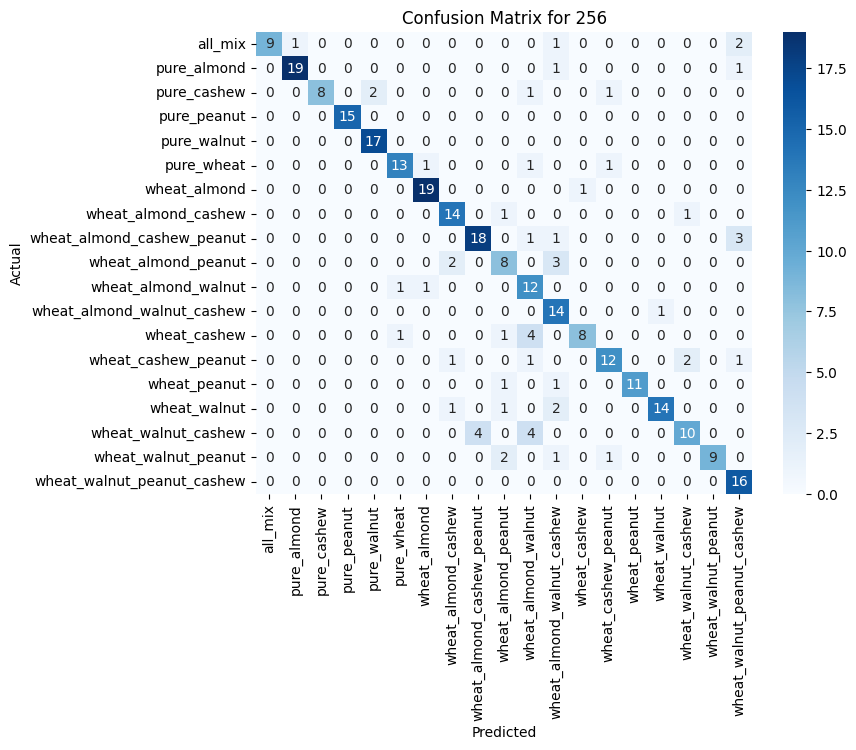

In [ ]:
# resnet reports
for image_size in image_sizes:
  # Set resnet to evaluation mode
  resnet_mappings[image_size].eval()

  # Containers for true labels and predicted labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader_mappings[image_size]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = resnet_mappings[image_size](inputs)
          _, preds = torch.max(outputs, 1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Classification Report
  print(f"\nClassification Report - {image_size}:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  # Confusion Matrix
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion Matrix for {image_size}')
  plt.show()

# **EfficientNet-B0**

In [ ]:
def train_efficient_net(train_loader,test_loader, image_size):
  # Load pretrained EfficientNet-B0
  efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

  # Modify the final layer
  num_classes = len(class_names)
  efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)

  efficientnet = efficientnet.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(efficientnet.parameters(), lr=0.001)

  # Training Loop
  num_epochs = epochs

  for epoch in range(num_epochs):
      efficientnet.train()
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = efficientnet(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          _, preds = torch.max(outputs, 1)
          correct += (preds == labels).sum().item()
          total += labels.size(0)

      train_loss = running_loss / len(train_loader)
      train_acc = correct / total

      # Validation Loop
      efficientnet.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = efficientnet(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()

              _, preds = torch.max(outputs, 1)
              val_correct += (preds == labels).sum().item()
              val_total += labels.size(0)

      val_loss /= len(test_loader)
      val_acc = val_correct / val_total

      print(f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  # Save the efficientnet
  torch.save(efficientnet.state_dict(), 'efficientnet_b0_finetuned.pth')
  return efficientnet

In [ ]:
efficientnet_mappings={}
for image_size in image_sizes:
  print(f"\nStarting with image size = {image_size}")
  efficientnet = train_efficient_net(train_loader_mappings[image_size], test_loader_mappings[image_size], image_size)
  efficientnet_mappings.update({image_size:efficientnet})


Starting with image size = 700
Epoch [1/20] Train Loss: 1.3596, Train Acc: 0.6053 Val Loss: 0.6756, Val Acc: 0.8125
Epoch [2/20] Train Loss: 0.6341, Train Acc: 0.8133 Val Loss: 0.6858, Val Acc: 0.8289
Epoch [3/20] Train Loss: 0.4147, Train Acc: 0.8692 Val Loss: 0.3244, Val Acc: 0.9145
Epoch [4/20] Train Loss: 0.2800, Train Acc: 0.9079 Val Loss: 0.1648, Val Acc: 0.9539
Epoch [5/20] Train Loss: 0.2353, Train Acc: 0.9342 Val Loss: 0.1765, Val Acc: 0.9474
Epoch [6/20] Train Loss: 0.1376, Train Acc: 0.9572 Val Loss: 0.0870, Val Acc: 0.9704
Epoch [7/20] Train Loss: 0.0968, Train Acc: 0.9688 Val Loss: 0.2518, Val Acc: 0.9276
Epoch [8/20] Train Loss: 0.1667, Train Acc: 0.9424 Val Loss: 0.3987, Val Acc: 0.8980
Epoch [9/20] Train Loss: 0.1431, Train Acc: 0.9613 Val Loss: 0.1530, Val Acc: 0.9441
Epoch [10/20] Train Loss: 0.1078, Train Acc: 0.9655 Val Loss: 0.1838, Val Acc: 0.9441
Epoch [11/20] Train Loss: 0.1592, Train Acc: 0.9556 Val Loss: 0.1832, Val Acc: 0.9375
Epoch [12/20] Train Loss: 0.127


Classification Report - 700:
                            precision    recall  f1-score   support

                   all_mix       0.89      1.00      0.94         8
               pure_almond       1.00      1.00      1.00        18
               pure_cashew       1.00      1.00      1.00        14
               pure_peanut       1.00      1.00      1.00        19
               pure_walnut       1.00      1.00      1.00        13
                pure_wheat       1.00      1.00      1.00        12
              wheat_almond       1.00      0.95      0.98        21
       wheat_almond_cashew       1.00      0.91      0.95        11
wheat_almond_cashew_peanut       1.00      0.92      0.96        13
       wheat_almond_peanut       0.93      1.00      0.96        13
       wheat_almond_walnut       0.91      0.91      0.91        23
wheat_almond_walnut_cashew       0.94      0.94      0.94        16
              wheat_cashew       0.95      0.95      0.95        20
       wheat_cash

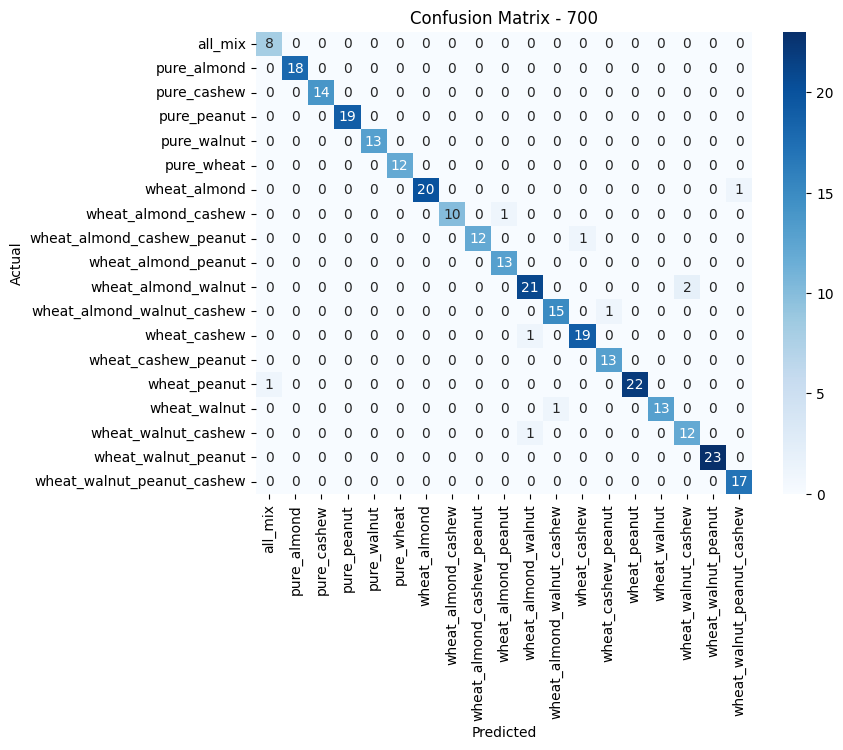


Classification Report - 512:
                            precision    recall  f1-score   support

                   all_mix       0.94      0.94      0.94        17
               pure_almond       1.00      0.93      0.96        14
               pure_cashew       0.93      1.00      0.97        14
               pure_peanut       0.94      1.00      0.97        17
               pure_walnut       1.00      1.00      1.00        15
                pure_wheat       0.83      0.88      0.86        17
              wheat_almond       0.79      0.88      0.83        17
       wheat_almond_cashew       1.00      0.86      0.92        14
wheat_almond_cashew_peanut       0.95      1.00      0.97        18
       wheat_almond_peanut       0.92      0.92      0.92        13
       wheat_almond_walnut       0.94      0.88      0.91        17
wheat_almond_walnut_cashew       0.93      0.87      0.90        15
              wheat_cashew       1.00      0.73      0.85        15
       wheat_cash

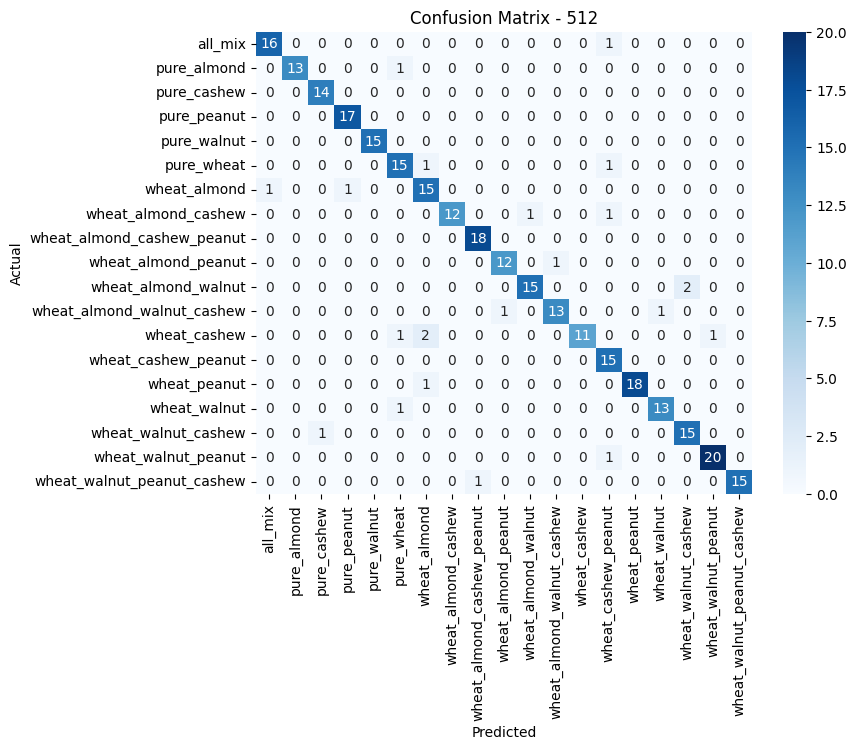


Classification Report - 256:
                            precision    recall  f1-score   support

                   all_mix       1.00      0.92      0.96        13
               pure_almond       0.95      1.00      0.98        21
               pure_cashew       1.00      0.92      0.96        12
               pure_peanut       0.93      0.93      0.93        15
               pure_walnut       0.94      1.00      0.97        17
                pure_wheat       1.00      0.88      0.93        16
              wheat_almond       0.95      0.95      0.95        20
       wheat_almond_cashew       1.00      0.81      0.90        16
wheat_almond_cashew_peanut       0.92      1.00      0.96        23
       wheat_almond_peanut       0.82      0.69      0.75        13
       wheat_almond_walnut       1.00      0.93      0.96        14
wheat_almond_walnut_cashew       0.92      0.73      0.81        15
              wheat_cashew       0.88      1.00      0.93        14
       wheat_cash

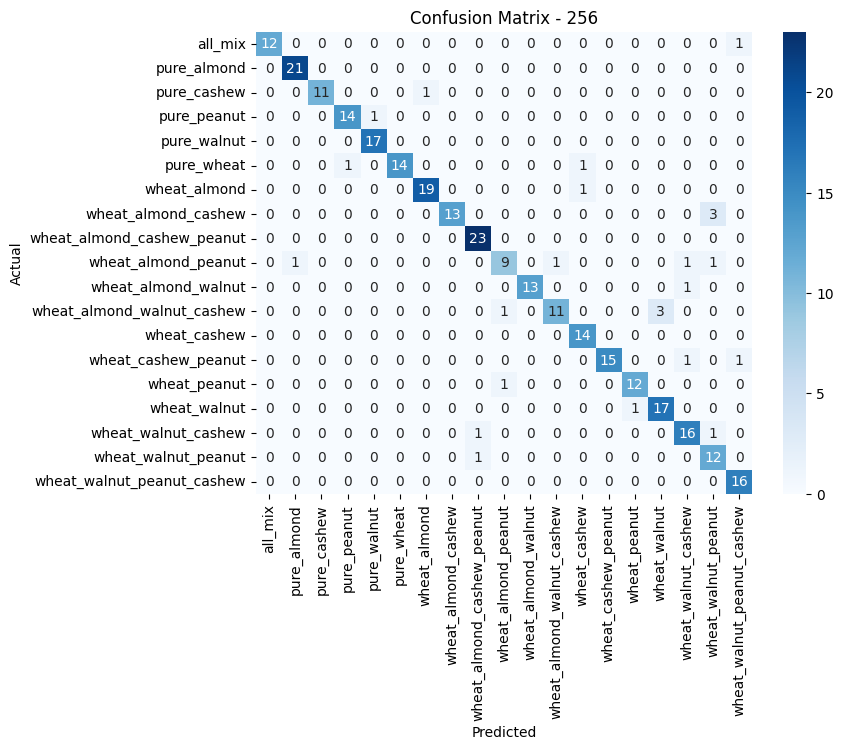

In [ ]:
for image_size in image_sizes:
  # Set efficientnet to evaluation mode
  efficientnet_mappings[image_size].eval()

  # Containers for true labels and predicted labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader_mappings[image_size]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = efficientnet_mappings[image_size](inputs)
          _, preds = torch.max(outputs, 1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Classification Report
  print(f"\nClassification Report - {image_size}:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  # Confusion Matrix
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion Matrix - {image_size}')
  plt.show()

# **DenseNet-121**

In [ ]:
def train_densenet(train_loader, test_loader, image_size):
  # Load pretrained DenseNet-121
  densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

  # Modify the final layer
  num_classes = len(class_names)
  densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)

  densenet = densenet.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(densenet.parameters(), lr=0.001)

  # Training Loop
  num_epochs = epochs

  for epoch in range(num_epochs):
      densenet.train()
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = densenet(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          _, preds = torch.max(outputs, 1)
          correct += (preds == labels).sum().item()
          total += labels.size(0)

      train_loss = running_loss / len(train_loader)
      train_acc = correct / total

      # Validation Loop
      densenet.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = densenet(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()

              _, preds = torch.max(outputs, 1)
              val_correct += (preds == labels).sum().item()
              val_total += labels.size(0)

      val_loss /= len(test_loader)
      val_acc = val_correct / val_total

      print(f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  # Save the densenet
  torch.save(densenet.state_dict(), 'densenet121_finetuned.pth')
  return densenet

In [ ]:
densenet_mappings={}
for image_size in image_sizes:
  print(f"\nStarting with image size = {image_size}")
  densenet = train_densenet(train_loader_mappings[image_size], test_loader_mappings[image_size], image_size)
  densenet_mappings.update({image_size:densenet})


Starting with image size = 700
Epoch [1/20] Train Loss: 1.3492, Train Acc: 0.5896 Val Loss: 2.3008, Val Acc: 0.6250
Epoch [2/20] Train Loss: 0.8224, Train Acc: 0.7599 Val Loss: 0.9730, Val Acc: 0.6678
Epoch [3/20] Train Loss: 0.4755, Train Acc: 0.8569 Val Loss: 0.5452, Val Acc: 0.8191
Epoch [4/20] Train Loss: 0.3552, Train Acc: 0.8865 Val Loss: 0.7352, Val Acc: 0.7796
Epoch [5/20] Train Loss: 0.2705, Train Acc: 0.9211 Val Loss: 0.3133, Val Acc: 0.9046
Epoch [6/20] Train Loss: 0.3138, Train Acc: 0.9054 Val Loss: 0.4981, Val Acc: 0.8191
Epoch [7/20] Train Loss: 0.3025, Train Acc: 0.9087 Val Loss: 0.3129, Val Acc: 0.8947
Epoch [8/20] Train Loss: 0.2637, Train Acc: 0.9243 Val Loss: 0.3741, Val Acc: 0.8849
Epoch [9/20] Train Loss: 0.1661, Train Acc: 0.9465 Val Loss: 0.2492, Val Acc: 0.9276
Epoch [10/20] Train Loss: 0.1359, Train Acc: 0.9539 Val Loss: 0.2853, Val Acc: 0.9243
Epoch [11/20] Train Loss: 0.1274, Train Acc: 0.9638 Val Loss: 0.2433, Val Acc: 0.9408
Epoch [12/20] Train Loss: 0.055


Classification Report-700:
                            precision    recall  f1-score   support

                   all_mix       1.00      0.62      0.77         8
               pure_almond       1.00      0.94      0.97        18
               pure_cashew       1.00      0.71      0.83        14
               pure_peanut       0.69      0.95      0.80        19
               pure_walnut       0.93      1.00      0.96        13
                pure_wheat       0.75      1.00      0.86        12
              wheat_almond       0.95      0.95      0.95        21
       wheat_almond_cashew       1.00      0.91      0.95        11
wheat_almond_cashew_peanut       0.85      0.85      0.85        13
       wheat_almond_peanut       1.00      0.85      0.92        13
       wheat_almond_walnut       0.96      1.00      0.98        23
wheat_almond_walnut_cashew       0.94      0.94      0.94        16
              wheat_cashew       1.00      0.85      0.92        20
       wheat_cashew

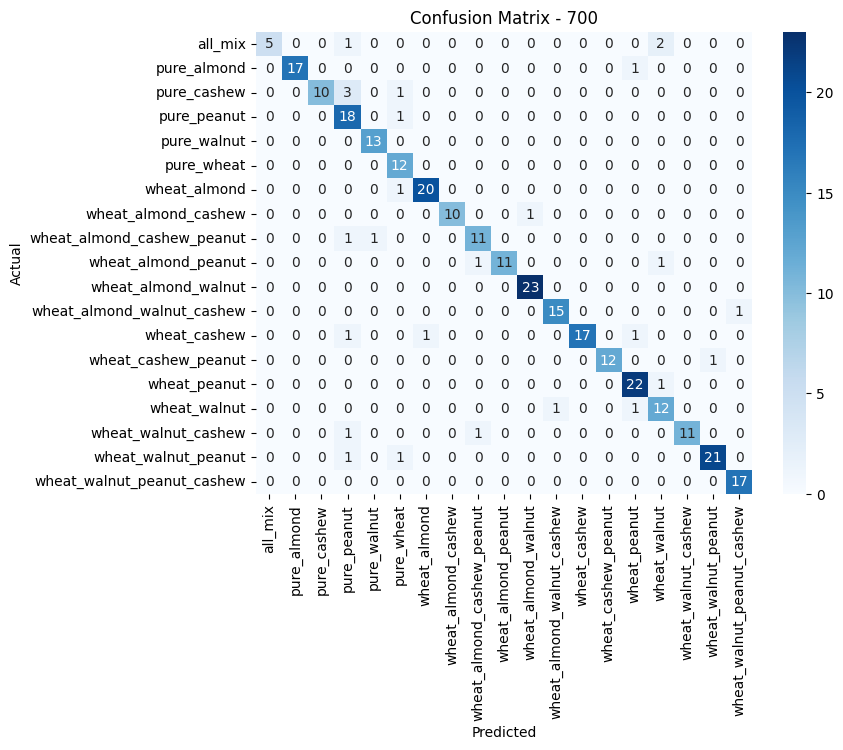


Classification Report-512:
                            precision    recall  f1-score   support

                   all_mix       0.55      1.00      0.71        17
               pure_almond       0.92      0.86      0.89        14
               pure_cashew       1.00      0.93      0.96        14
               pure_peanut       0.71      1.00      0.83        17
               pure_walnut       1.00      1.00      1.00        15
                pure_wheat       0.89      0.94      0.91        17
              wheat_almond       1.00      0.59      0.74        17
       wheat_almond_cashew       1.00      0.21      0.35        14
wheat_almond_cashew_peanut       1.00      0.61      0.76        18
       wheat_almond_peanut       0.35      0.92      0.51        13
       wheat_almond_walnut       1.00      0.53      0.69        17
wheat_almond_walnut_cashew       0.73      0.53      0.62        15
              wheat_cashew       0.87      0.87      0.87        15
       wheat_cashew

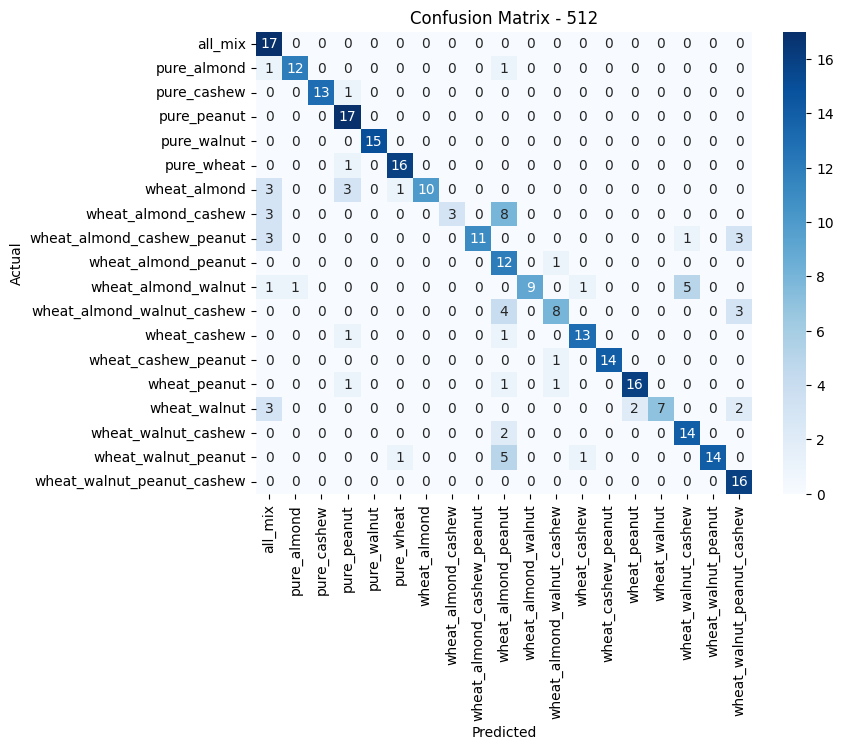


Classification Report-256:
                            precision    recall  f1-score   support

                   all_mix       0.92      0.92      0.92        13
               pure_almond       1.00      0.90      0.95        21
               pure_cashew       1.00      0.83      0.91        12
               pure_peanut       0.83      1.00      0.91        15
               pure_walnut       0.89      1.00      0.94        17
                pure_wheat       0.94      1.00      0.97        16
              wheat_almond       0.91      1.00      0.95        20
       wheat_almond_cashew       0.65      0.69      0.67        16
wheat_almond_cashew_peanut       0.95      0.78      0.86        23
       wheat_almond_peanut       0.61      0.85      0.71        13
       wheat_almond_walnut       1.00      0.64      0.78        14
wheat_almond_walnut_cashew       1.00      0.60      0.75        15
              wheat_cashew       0.92      0.86      0.89        14
       wheat_cashew

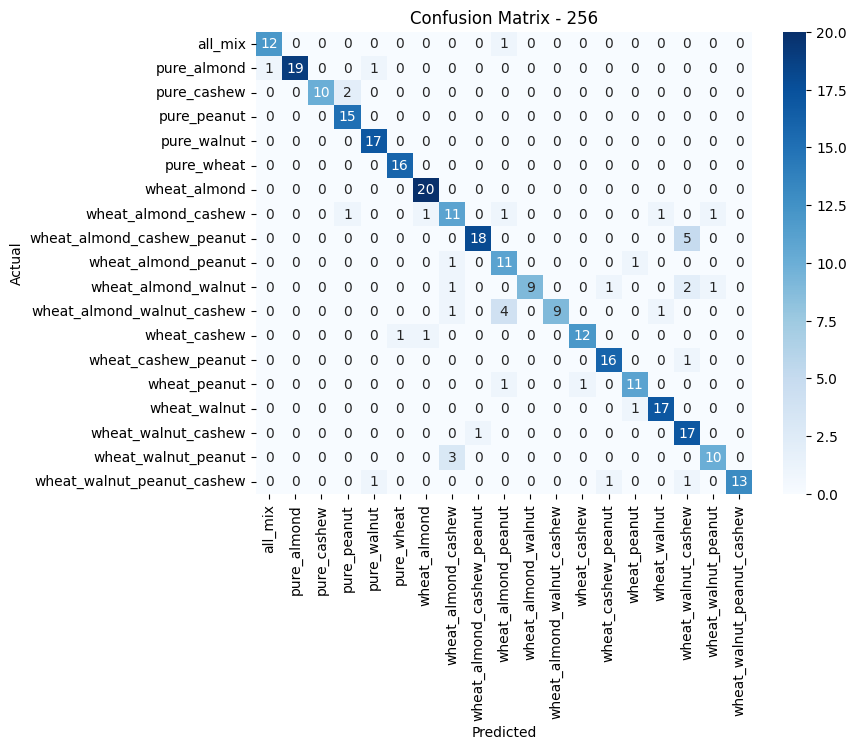

In [ ]:
for image_size in image_sizes:
  # Set densenet to evaluation mode
  densenet_mappings[image_size].eval()

  # Containers for true labels and predicted labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader_mappings[image_size]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = densenet_mappings[image_size](inputs)
          _, preds = torch.max(outputs, 1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Classification Report
  print(f"\nClassification Report-{image_size}:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  # Confusion Matrix
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion Matrix - {image_size}')
  plt.show()

In [ ]:
for image_size in image_sizes:
  torch.save(trained_model_mappings[image_size].state_dict(), f'customcnn_{image_size}.pth')
  torch.save(resnet_mappings[image_size].state_dict(), f'resnet_{image_size}.pth')
  torch.save(efficientnet_mappings[image_size].state_dict(), f'efficientnet_{image_size}.pth')
  torch.save(densenet_mappings[image_size].state_dict(), f'densenet_{image_size}.pth')